<img src="Quantum_Brilliance_dark_blue_Logo_RGB.png" alt="Copyright (c) 2021 Quantum Brilliance Pty Ltd" width="240">

# qbOS Build 0.0721.002
> *Quantum Brilliance Operating System supporting a complete set of quantum computational tasks*

In [1]:
import re
import time

### Inputs from user

In [2]:
qn = [8,10,12,14] # The number of qubits
repeatn = 2 # The number of repeated evaluations
fit_qn_max = 32   # Upper limit for extrapolation

### Circuit generator

In [3]:
def qbdj(qn) :
    import xacc
    import re
    bitstr = [1,0]*(qn//2)
    xgates_str=''.join(['X(q['+str(mye[0])+']);' for mye in enumerate(bitstr) if mye[1]==1])
    
    generator = '''
.compiler xasm
.circuit dj_circuit
.qbit q
for (int i=0; i<%d; i++) {
  H(q[i]);
}

Z(q[%d]);
// End of init

// Start of oracle
%s
for (int i=0; i<%d; i++) {
  CNOT(q[i], q[%d]);
}
%s
// End of oracle
for (int i=0; i<%d; i++) {
  H(q[i]);
}

// Measurements
for (int i=0; i<%d; i++) {
  Measure(q[i]);
}

''' % (qn+1,qn,xgates_str,qn,qn,xgates_str,qn,qn)
    xacc.qasm(generator)
    anz = xacc.getCompiled('dj_circuit')
    mstaq = xacc.getCompiler('staq')
    q2oqm = re.sub(r"qreg q\[\d+\];", "", mstaq.translate(anz))
    qbstr = '__qpu__ void QBCIRCUIT(qreg q) {\n' + q2oqm + '}'
    return(qbstr)

In [4]:
qubit_range = []
for ii in range(0,len(qn)):
    qubit_range += [qn[ii]]*repeatn

In [5]:
sweepstr = [qbdj(el) for el in qubit_range]

In [6]:
# print(sweepstr[-1])

### Setup simulation conditions

In [7]:
import qbos
tqb=qbos.core()
tqb.qb12()
tqb.acc = 'aer'
tqb.noise = True

In [8]:
tqb.qns.clear()
for ii in range(0,len(qn)):
    for kk in range(0,repeatn):
        tqb.qns.append(qbos.N())
        tqb.qns[repeatn*ii+kk].append(1+qn[ii])

In [9]:
tqb.instrings.clear()
for ii in range(0,len(qn)):
    for kk in range(0,repeatn):
        tqb.instrings.append(qbos.String())
        tqb.instrings[repeatn*ii+kk].append(sweepstr[repeatn*ii+kk])

### Execute the quantum circuits

In [10]:
tqb.run()

### Measurements from shots

In [11]:
# [tqb.out_raw[ii] for ii in range (0,repeatn*len(qn))]

### Calculate infidelity 

In [12]:
all_ones = [tqb.out_count[el][0][2**qubit_range[el] - 1] for el in range(0,len(qubit_range))]

In [13]:
infidelity = [(1.0/tqb.sn[0][0])*(tqb.sn[0][0] - el) for el in all_ones]

In [14]:
fidelity = [1 - el for el in infidelity]

### Quantum estimated walltime (in ms)

In [15]:
quantum_ms = [tqb.out_total_init_maxgate_readout_time[ii][0][0] for ii in range (0,len(qubit_range))]

### Classical algorithm

In [16]:
def oracle(value):
    pass
    return 0

In [17]:
def check_DJ(nb_bits):
    first_value = oracle(0)
    max_val = 2**(nb_bits - 1) + 1
    for value in range(1,max_val):
        if oracle(value) != first_value:
            return 1
    return 0

In [18]:
cext_qn = qn + list(range(qn[-1]+1, fit_qn_max+1))
cext_qubit_range = []
for ii in range(0,len(cext_qn)):
    cext_qubit_range += [cext_qn[ii]]*repeatn
    
classic_time = [0.0] * len(cext_qubit_range)
outcomes = [0] * len(cext_qubit_range)
for index_bits in range(len(cext_qubit_range)):
    nb_bits = cext_qubit_range[index_bits]
    time_1 = time.time()
    outcomes[index_bits] = check_DJ(nb_bits)
    time_2 = time.time()
    classic_time[index_bits] = time_2 - time_1

### Classical walltime (in seconds)

In [19]:
# print(classic_time)

### Visualise Quantum Utility

In [20]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from scipy import optimize
from scipy import stats

In [21]:
linfunc = lambda p,x : p[0] + np.multiply(p[1],x)
expfunc = lambda p,x : np.multiply(p[0],np.exp(np.multiply(p[1],x)))
powfunc = lambda p,x : p[0]*x**p[1]
errfunc_lin = lambda p,x,y : y - linfunc(p,x)
errfunc_exp = lambda p,x,y : y - expfunc(p,x)
errfunc_pow = lambda p,x,y : y - powfunc(p,x)
linplot = lambda x,b,slope: b + x*slope
expplot = lambda x,amp,coeff: amp*np.exp(coeff*x)
powplot = lambda x,amp,pow: amp*x**pow

In [22]:
plot_range = qn
cext_plot_range = cext_qn
fit_range = qn + list(range((qn[-1]+1), fit_qn_max+1))

In [23]:
classical_data = np.array([cext_qubit_range,classic_time])
classical_mean=[np.mean(classical_data[1,classical_data[0,:] == iik]) for iik in cext_qn]

In [24]:
p_class = optimize.leastsq(errfunc_exp,np.array([1.0,0.1]),args=(cext_qn,classical_mean))
classical_fit = [expfunc(p_class[0],x) for x in fit_range]

In [25]:
quantum_data = np.array([qubit_range,np.multiply((1/1000),quantum_ms)])
quantum_mean=[np.mean(quantum_data[1,quantum_data[0,:] == iik]) for iik in qn]

In [26]:
p_quantum = optimize.leastsq(errfunc_lin,np.array([1.0,0.1]),args=(qn,quantum_mean))
quantum_fit = [linfunc(p_quantum[0],x) for x in fit_range]

In [27]:
infidelity_data = np.array([qubit_range,infidelity])
infidelity_mean = [np.mean(infidelity_data[1,infidelity_data[0,:] == iik]) for iik in qn]

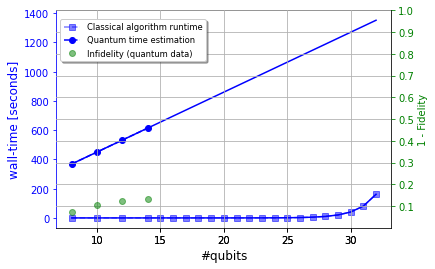

In [28]:
from pylab import figure, show, legend, ylabel
import math
 
# create the general figure
fig1 = figure()

# and the first axes using subplot populated with data 
ax1 = fig1.add_subplot(111)
line1 = ax1.plot(cext_plot_range,classical_mean, 'gs-', linestyle="dashed", label='Classical algorithm runtime', alpha=0.5, color='blue')
line3 = ax1.plot(plot_range,quantum_mean,'bo-', linestyle="dashed",label='Quantum time estimation')
ax1.plot(fit_range,quantum_fit, color='blue')  
ax1.plot(fit_range,classical_fit, color='blue') 
ax1.yaxis.label.set_color('blue')
ax1.tick_params(axis='y',colors='blue')
ax1.spines['left'].set_color('blue')
 
plt.xlabel("#qubits", fontsize='large')
plt.ylabel("wall-time [seconds]", fontsize='large')

# now, the second axes that shares the x-axis with the ax1
ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
line2 = ax2.plot(plot_range,infidelity_mean, 'om-',linestyle="None", label="Infidelity (quantum data)",color='green',alpha=0.5)
ax2.yaxis.tick_right()
ax2.set_ylim(0.0,1.0)
ax2.yaxis.set_label_position("right")
ax2.set_yticks([i/10 for i in range(1,11)])
ax2.tick_params(axis='y',colors='green')
ax2.spines['right'].set_color('green')
ax2.yaxis.label.set_color('green')
ax2.grid()
ylabel("1 - Fidelity")
fig1.legend(bbox_to_anchor=(0.13, 0.78, 1., .102),loc='upper left', shadow=True, fontsize='small')

plt.savefig('qbstrDJ.png', dpi=300)
show()